In [1]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             f1_score, roc_auc_score, classification_report,
                             make_scorer, accuracy_score)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import optuna
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger,
    Doc
)

c:\Users\maxod\Desktop\tutorial\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
username = 'doadmin'
password = 'AVNS_pWw7oK1YPADBn-TRPqp'
host = 'db-postgresql-fra1-12797-do-user-8775628-0.c.db.ondigitalocean.com'
port = '25060'
database = 'defaultdb'
conn_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'

# Компании

In [3]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe = pd.read_sql_query('SELECT * FROM companies_trade', conn)
conn.close()

print(dataframe.shape)
dataframe.head()

(7267, 17)


,website,section,url,header,body,tags,body_length,datetime,company,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,SBER,142.75,11917688.40,142.62,2958789.90,-0.13,-0.091068,-8958898.5,-75.173122
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,GAZP,163.13,1100961.10,163.37,1413064.30,0.24,0.147122,312103.2,28.348250
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,ROSN,363.70,178263.05,364.85,321423.75,1.15,0.316195,143160.7,80.308679
3,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,SBER,141.31,1573757.40,141.40,2401025.00,0.09,0.063690,827267.6,52.566399
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,GAZP,161.69,4620114.20,161.60,1373716.00,-0.09,-0.055662,-3246398.2,-70.266622


In [4]:
additional_stopwords = [
    'которых', 'которые', 'твой', 'которой', 'которого', 'сих', 'ком', 'свой',
    'твоя', 'этими', 'слишком', 'нами', 'всему', 'будь', 'саму', 'чаще',
    'ваше', 'сами', 'наш', 'затем', 'самих', 'наши', 'ту', 'каждое', 'мочь',
    'весь', 'этим', 'наша', 'своих', 'оба', 'который', 'зато', 'те', 'этих',
    'вся', 'ваш', 'такая', 'теми', 'ею', 'которая', 'нередко', 'каждая',
    'также', 'чему', 'собой', 'самими', 'нем', 'вами', 'ими', 'откуда',
    'такие', 'тому', 'та', 'очень', 'сама', 'нему', 'алло', 'оно', 'этому',
    'кому', 'тобой', 'таки', 'твоё', 'каждые', 'твои', 'нею', 'самим', 'ваши',
    'ваша', 'кем', 'мои', 'однако', 'сразу', 'свое', 'ними', 'всё', 'неё',
    'тех', 'хотя', 'всем', 'тобою', 'тебе', 'одной', 'другие', 'само', 'эта',
    'самой', 'моё', 'своей', 'такое', 'всею', 'будут', 'своего', 'кого',
    'свои', 'мог', 'нам', 'особенно', 'её', 'самому', 'наше', 'кроме',
    'вообще', 'вон', 'мною', 'никто', 'это'
]

stop_words = stopwords.words('russian') + additional_stopwords

In [5]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

ner_tagger = NewsNERTagger(emb)

In [6]:
del_n = re.compile('\n')
del_tags = re.compile('<[^>]*>')
del_brackets = re.compile('\([^)]*\)')
clean_text = re.compile('[^а-яa-z\s]')
del_spaces = re.compile('\s{2,}')


def prepare_text(text):
    text = del_n.sub(' ', str(text).lower())
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)
    res_text = clean_text.sub('', text)
    return del_spaces.sub(' ', res_text)


def del_stopwords(text):
    clean_tokens = tuple(
        map(lambda x: x if x not in stop_words else '', word_tokenize(text)))
    res_text = ' '.join(clean_tokens)
    return res_text


def lemmatize(text):
    text = Doc(text)
    text.segment(segmenter)
    text.tag_morph(morph_tagger)
    for token in text.tokens:
        token.lemmatize(morph_vocab)
    text.tag_ner(ner_tagger)
    for span in text.spans:
        span.normalize(morph_vocab)
    return ' '.join([token.lemma for token in text.tokens])

In [7]:
txt_lst = []
txts = dataframe.body.copy()

for text in tqdm(txts):
    text = prepare_text(text)
    text = del_stopwords(text)
    text = lemmatize(text)
    txt_lst.append(text)

  0%|          | 1/7267 [00:00<17:18,  7.00it/s]

100%|██████████| 7267/7267 [04:34<00:00, 26.48it/s]


In [8]:
df_comp_safe = pd.concat(
    [dataframe, pd.DataFrame(txt_lst, columns=['text_clear'])],
    axis=1
)

df_comp_safe.to_csv('texts_comp.csv', index=False)

In [9]:
del_n = re.compile('\n')
del_tags = re.compile('<[^>]*>')
del_brackets = re.compile('\([^)]*\)')
clean_text = re.compile('[^а-яa-z\s]')
del_spaces = re.compile('\s{2,}')


def prepare_text(text):
    text = del_n.sub(' ', str(text).lower())
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)
    res_text = clean_text.sub('', text)
    return del_spaces.sub(' ', res_text)

df_comp = pd.read_csv('texts_comp.csv')

for i, text in enumerate(df_comp.text_clear):
    df_comp.loc[i, 'text_clear'] = prepare_text(text).strip()

In [10]:
def plot_confusion_matrix(y_test, y_preds, model):
    fig, ax = plt.subplots(figsize=(16, 10))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(
        cm, display_labels=[j - 1 for j in model.classes_])
    cmp.plot(ax=ax)
    plt.show()

In [11]:
p = 0.05

q_l = df_comp.price_diff_percent.quantile(p)
q_u = df_comp.price_diff_percent.quantile(1-p)

df_comp['price_diff_cat'] = 1
df_comp.loc[df_comp['price_diff_percent'] <= q_l, 'price_diff_cat'] = 0
df_comp.loc[df_comp['price_diff_percent'] >= q_u, 'price_diff_cat'] = 2

df_comp[['price_diff_cat']].groupby('price_diff_cat').value_counts()

price_diff_cat
0     364
1    6539
2     364
Name: count, dtype: int64

In [12]:
df_comp.describe()

,body_length,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent,price_diff_cat
count,7267.000000,7267.000000,7.267000e+03,7267.000000,7.267000e+03,7267.000000,7267.000000,7.267000e+03,7267.000000,7267.000000
mean,1952.959543,1491.862511,7.887541e+06,1491.773309,5.721324e+06,-0.089202,0.002461,-2.166217e+06,528.523294,1.000000
std,1804.111893,3225.549159,3.161944e+07,3225.317056,2.021367e+07,14.817624,0.521579,2.656147e+07,5328.539323,0.316532
min,202.000000,0.003740,2.494000e+02,0.003700,1.628900e+02,-708.500000,-5.813333,-6.565861e+08,-99.991628,0.000000
25%,997.000000,71.025000,2.371487e+05,71.000000,1.793270e+05,-0.400000,-0.164353,-1.513370e+06,-73.011939,1.000000
50%,1496.000000,255.700000,1.192395e+06,256.000000,9.488263e+05,0.000000,0.000000,-4.558780e+04,-20.351958,1.000000
75%,2338.000000,1281.000000,4.804763e+06,1281.000000,4.029187e+06,0.380000,0.154965,5.952707e+05,138.065313,1.000000
max,32767.000000,49320.000000,1.033405e+09,49400.000000,6.271164e+08,280.000000,9.756098,3.439704e+08,278627.457343,2.000000


In [13]:
X, y = np.array(df_comp['text_clear']), np.array(df_comp['price_diff_cat'].values)

In [14]:
vectorizer = TfidfVectorizer(min_df=50)
vect_x = vectorizer.fit_transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(vect_x,
                                                    y,
                                                    random_state=23,
                                                    test_size=0.25,
                                                    stratify=y)

X_res, Y_res = X_train, y_train

In [16]:
train_x, valid_x, train_y, valid_y = train_test_split(X_res,
                                                      Y_res,
                                                      random_state=23,
                                                      test_size=0.25,
                                                      stratify=Y_res)

## SVC

In [17]:
def objective(trial):
    svc_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    svc_degree = trial.suggest_int('degree', 2, 5, 1, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    svc_c = trial.suggest_float("C", 1e-2, 1e2, log=True)
    clf = SVC(C=svc_c, gamma=svc_gamma, degree=svc_degree, kernel=svc_kernel)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [18]:
study = optuna.create_study(study_name="svc", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 04:16:37,173] A new study created in memory with name: svc
[I 2023-12-17 04:16:41,904] Trial 0 finished with value: 0.31583011583011583 and parameters: {'kernel': 'rbf', 'degree': 3, 'gamma': 'auto', 'C': 0.138250201858293}. Best is trial 0 with value: 0.31583011583011583.
[I 2023-12-17 04:16:46,316] Trial 1 finished with value: 0.31583011583011583 and parameters: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto', 'C': 0.209299787008471}. Best is trial 0 with value: 0.31583011583011583.
[I 2023-12-17 04:17:06,536] Trial 2 finished with value: 0.4126598344361638 and parameters: {'kernel': 'rbf', 'degree': 4, 'gamma': 'scale', 'C': 83.77828612236799}. Best is trial 2 with value: 0.4126598344361638.
[I 2023-12-17 04:17:11,513] Trial 3 finished with value: 0.31583011583011583 and parameters: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto', 'C': 2.08805627483921}. Best is trial 2 with value: 0.4126598344361638.
[I 2023-12-17 04:17:16,736] Trial 4 finished with value: 0.315830115

0.39769284612653827


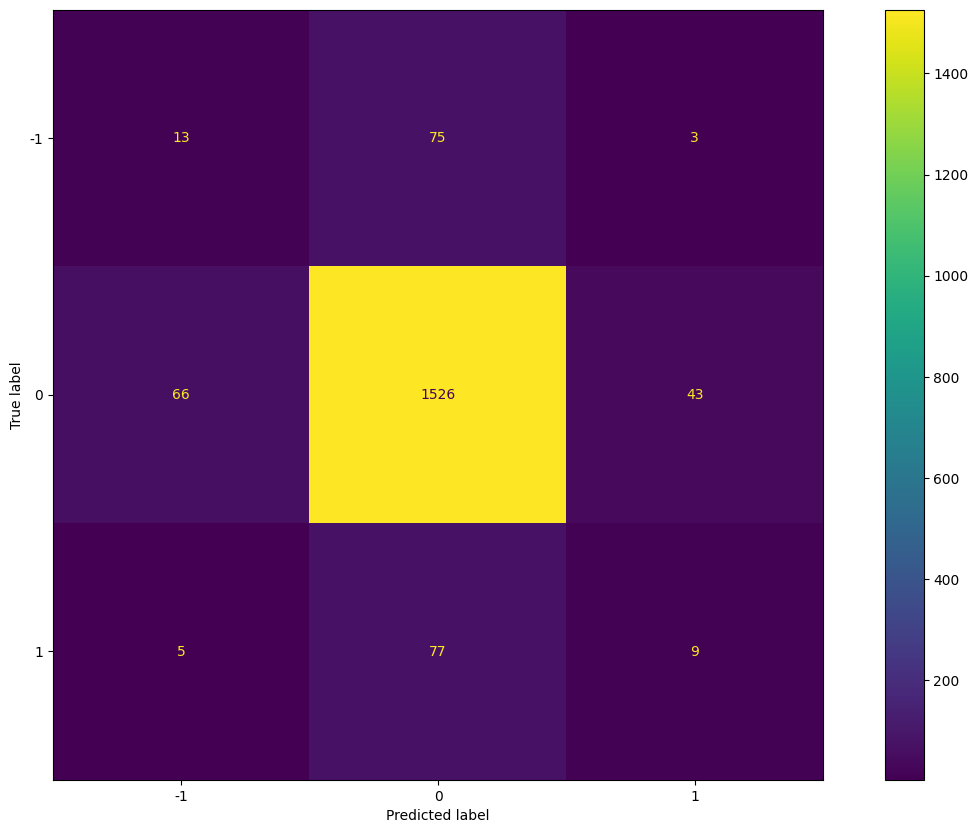

In [19]:
clf = SVC(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## KNN

In [20]:
def objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 3, 15, 1, log=True)
    knn_weights = trial.suggest_categorical('weights', ['uniform','distance'])
    knn_metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    clf = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, metric=knn_metric)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [21]:
study = optuna.create_study(study_name="knn", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 04:35:02,268] A new study created in memory with name: knn
c:\Users\maxod\Desktop\tutorial\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\maxod\Desktop\tutorial\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\maxod\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\maxod\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executab

0.40116398967931244


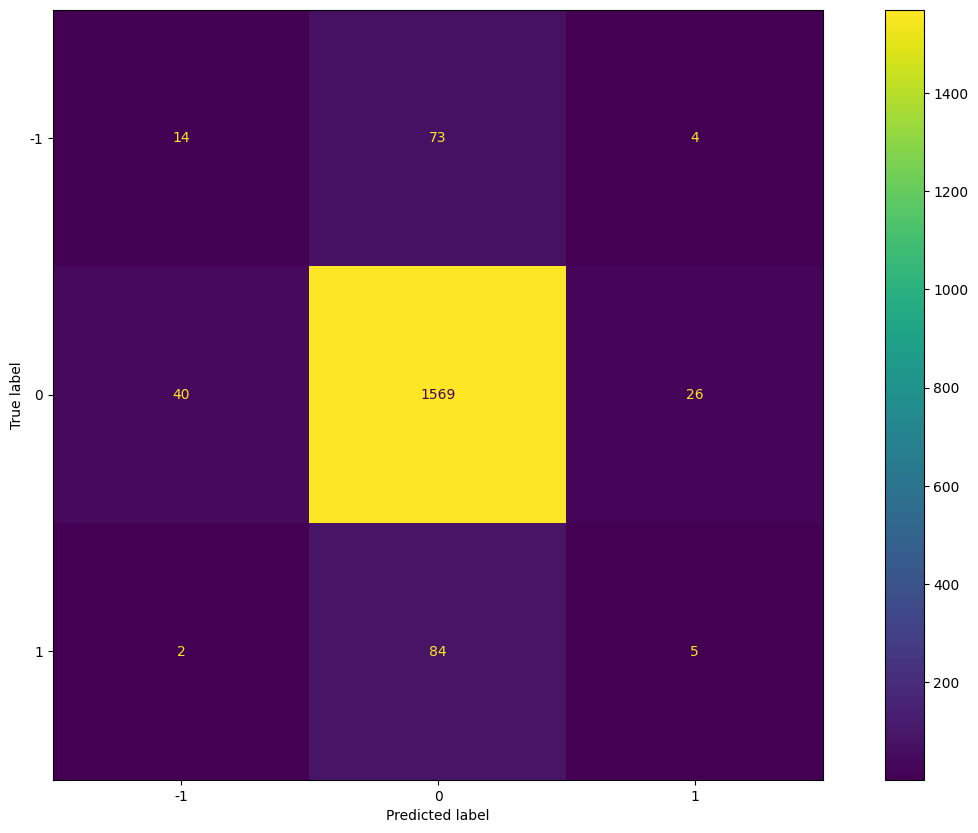

In [22]:
clf = KNeighborsClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## LogReg

In [23]:
def objective(trial):
    logreg_solver = trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga','lbfgs'])
    logereg_C = trial.suggest_float('C', 1e-2, 1e2, log=True)
    clf = LogisticRegression(multi_class='multinomial', solver=logreg_solver, C=logereg_C, max_iter=1000)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [24]:
study = optuna.create_study(study_name="logreg", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 04:51:28,659] A new study created in memory with name: logreg
[I 2023-12-17 04:51:29,040] Trial 0 finished with value: 0.31583011583011583 and parameters: {'solver': 'lbfgs', 'C': 1.0744512986073198}. Best is trial 0 with value: 0.31583011583011583.
[I 2023-12-17 04:51:29,201] Trial 1 finished with value: 0.31583011583011583 and parameters: {'solver': 'newton-cg', 'C': 0.01707727868540135}. Best is trial 0 with value: 0.31583011583011583.
[I 2023-12-17 04:51:29,372] Trial 2 finished with value: 0.31583011583011583 and parameters: {'solver': 'sag', 'C': 1.0030584320451827}. Best is trial 0 with value: 0.31583011583011583.
[I 2023-12-17 04:51:29,505] Trial 3 finished with value: 0.31583011583011583 and parameters: {'solver': 'sag', 'C': 0.04310727549992157}. Best is trial 0 with value: 0.31583011583011583.
[I 2023-12-17 04:51:29,679] Trial 4 finished with value: 0.31583011583011583 and parameters: {'solver': 'sag', 'C': 1.1319470745187028}. Best is trial 0 with value: 0.315

c:\Users\maxod\Desktop\tutorial\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.3880263591669291


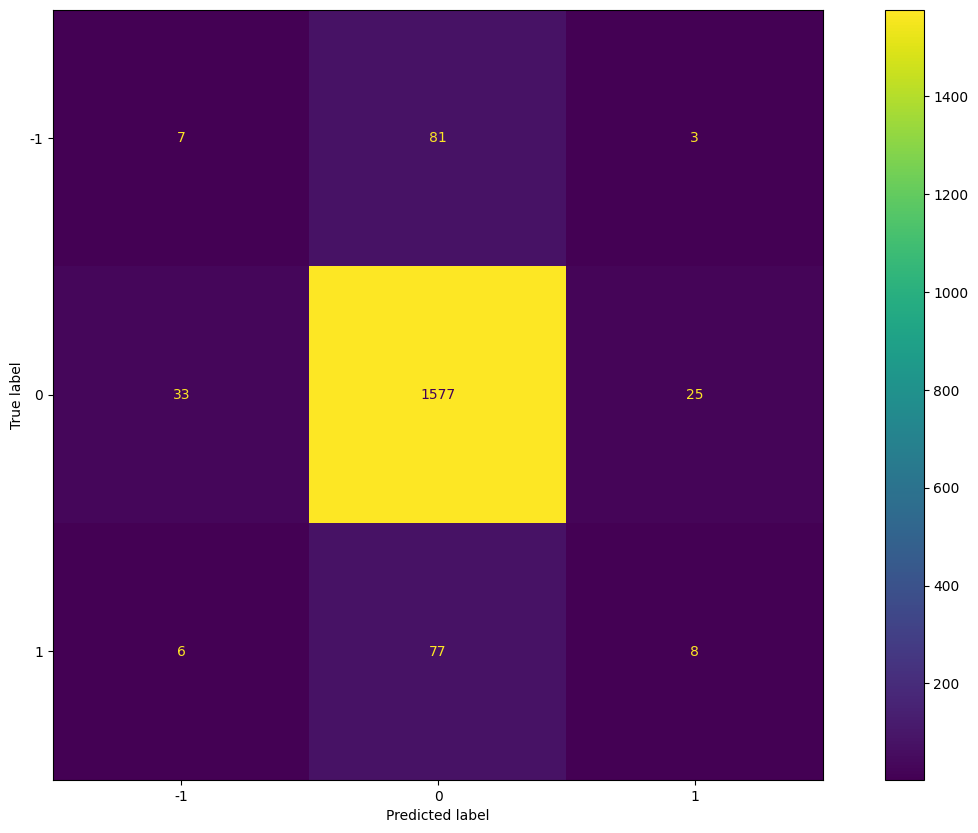

In [25]:
clf = LogisticRegression(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## RandomForest

In [26]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000, log=True)
    max_depth = trial.suggest_int("max_depth", 10, 100, log=True)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [27]:
study = optuna.create_study(study_name="forest", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 04:53:47,969] A new study created in memory with name: forest
[I 2023-12-17 04:55:00,742] Trial 0 finished with value: 0.408284430346286 and parameters: {'n_estimators': 509, 'max_depth': 29, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.408284430346286.
[I 2023-12-17 04:55:16,761] Trial 1 finished with value: 0.40863926855436866 and parameters: {'n_estimators': 184, 'max_depth': 19, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.40863926855436866.
[I 2023-12-17 04:55:38,194] Trial 2 finished with value: 0.40183898037142424 and parameters: {'n_estimators': 135, 'max_depth': 33, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.40863926855436866.
[I 2023-12-17 04:56:48,199] Trial 3 finished with value: 0.40098899934125276 and parameters: {'n_estimators': 314, 'max_depth': 64, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.40863926855436866.
[I 2023-12-17 04:57:33,475] Trial 4 finished with value: 0.40009057871651676 a

0.3867506537919936


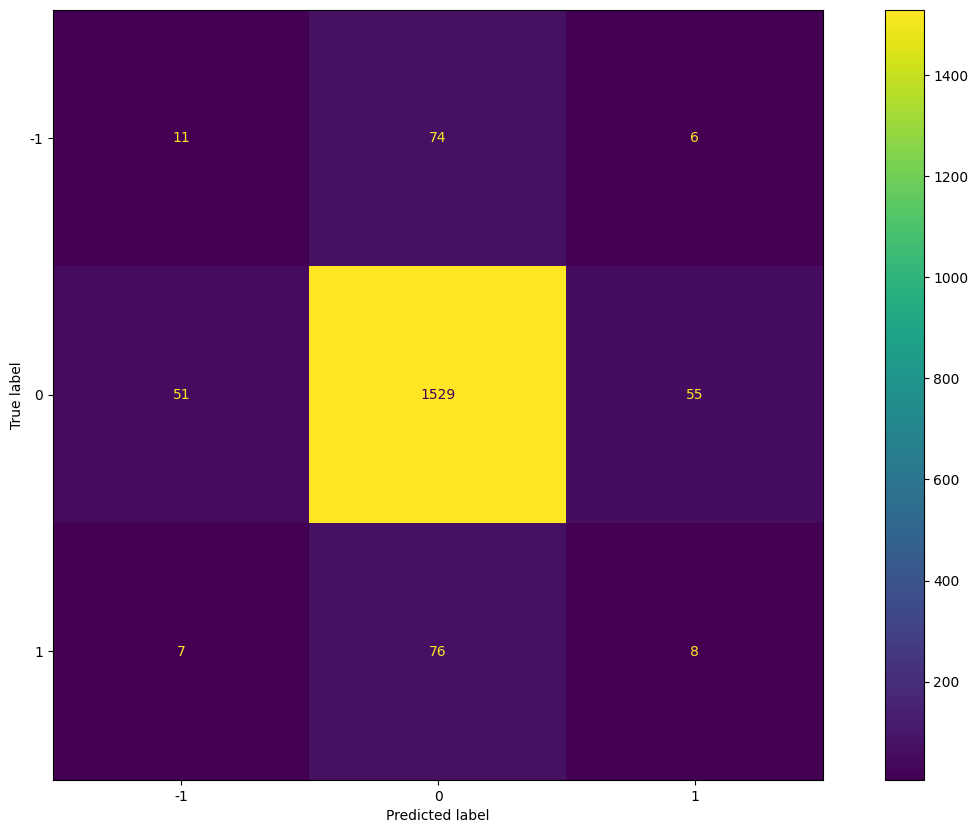

In [28]:
clf = RandomForestClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

# Индустрии

In [29]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe_ind = pd.read_sql_query('SELECT * FROM industries_trade', conn)
conn.close()

print(dataframe_ind.shape)
dataframe_ind.head()

(4755, 17)


,website,section,url,header,body,tags,body_length,datetime,industry,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,MOEXFN,6307.20,16806757.15,6308.77,11854100.00,1.57,0.024892,-4952657.15,-29.468250
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,MOEXOG,5696.30,4451180.75,5696.72,4605859.35,0.42,0.007373,154678.60,3.475002
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,MOEXOG,5655.65,3325798.35,5663.65,1490555.35,8.00,0.141451,-1835243.00,-55.182029
3,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXFN,6298.36,7394623.45,6296.27,3371524.05,-2.09,-0.033183,-4023099.40,-54.405737
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXOG,5655.00,15940301.65,5647.93,1358915.70,-7.07,-0.125022,-14581385.95,-91.474969


In [30]:
txt_lst = []
txts = dataframe_ind.body.copy()

for text in tqdm(txts):
    text = prepare_text(text)
    text = del_stopwords(text)
    text = lemmatize(text)
    txt_lst.append(text)

100%|██████████| 4755/4755 [01:54<00:00, 41.40it/s]


In [31]:
df_ind_safe = pd.concat(
    [dataframe_ind, pd.DataFrame(txt_lst, columns=['text_clear'])],
    axis=1
)

df_ind_safe.to_csv('texts_ind.csv', index=False)

In [32]:
df_ind = pd.read_csv('texts_ind.csv')

for i, text in enumerate(df_ind.text_clear):
    df_ind.loc[i, 'text_clear'] = prepare_text(text).strip()

In [33]:
p = 0.05

q_l = df_ind.price_diff_percent.quantile(p)
q_u = df_ind.price_diff_percent.quantile(1-p)

df_ind['price_diff_cat'] = 1
df_ind.loc[df_ind['price_diff_percent'] <= q_l, 'price_diff_cat'] = 0
df_ind.loc[df_ind['price_diff_percent'] >= q_u, 'price_diff_cat'] = 2

df_ind[['price_diff_cat']].groupby('price_diff_cat').value_counts()

price_diff_cat
0     238
1    4279
2     238
Name: count, dtype: int64

In [34]:
df_ind.describe()

,body_length,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent,price_diff_cat
count,4755.000000,4755.000000,4.755000e+03,4755.000000,4.755000e+03,4755.000000,4755.000000,4.755000e+03,4755.000000,4755.000000
mean,1767.579811,7413.158797,3.820572e+07,7413.186601,3.165379e+07,0.027804,0.002538,-6.551927e+06,95.293698,1.000000
std,1592.462497,5064.177935,7.411692e+07,5063.749307,5.703261e+07,23.365797,0.271261,6.895301e+07,620.845172,0.316427
min,203.000000,797.340000,4.104400e+03,796.810000,2.542000e+03,-376.840000,-3.976298,-1.091141e+09,-99.930102,0.000000
25%,939.000000,6006.255000,6.628012e+06,6009.615000,5.992865e+06,-6.470000,-0.107233,-1.340766e+07,-56.462377,1.000000
50%,1409.000000,7280.860000,1.627919e+07,7281.670000,1.497770e+07,0.230000,0.004961,-1.035134e+06,-15.995331,1.000000
75%,2158.500000,8587.900000,3.964378e+07,8582.270000,3.357984e+07,7.570000,0.119216,5.404258e+06,65.988172,1.000000
max,32767.000000,42515.650000,1.212407e+09,42521.770000,1.029316e+09,390.430000,1.959216,7.443854e+08,22259.393510,2.000000


In [35]:
X, y = np.array(df_ind['text_clear']), np.array(df_ind['price_diff_cat'].values)

In [36]:
vectorizer = TfidfVectorizer(min_df=50)
vect_x = vectorizer.fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(vect_x,
                                                    y,
                                                    random_state=23,
                                                    test_size=0.25,
                                                    stratify=y)

X_res, Y_res = X_train, y_train

In [38]:
train_x, valid_x, train_y, valid_y = train_test_split(X_res,
                                                      Y_res,
                                                      random_state=23,
                                                      test_size=0.25,
                                                      stratify=Y_res)

## SVC

In [39]:
def objective(trial):
    svc_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    svc_degree = trial.suggest_int('degree', 2, 5, 1, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    svc_c = trial.suggest_float("C", 1e-2, 1e2, log=True)
    clf = SVC(C=svc_c, gamma=svc_gamma, degree=svc_degree, kernel=svc_kernel)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [40]:
study = optuna.create_study(study_name="svc", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 05:11:20,156] A new study created in memory with name: svc
[I 2023-12-17 05:11:24,040] Trial 0 finished with value: 0.3158308751229105 and parameters: {'kernel': 'linear', 'degree': 2, 'gamma': 'scale', 'C': 0.016161864416868846}. Best is trial 0 with value: 0.3158308751229105.
[I 2023-12-17 05:11:25,727] Trial 1 finished with value: 0.3158308751229105 and parameters: {'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'C': 0.24480813820020814}. Best is trial 0 with value: 0.3158308751229105.
[I 2023-12-17 05:11:36,965] Trial 2 finished with value: 0.36707283366535765 and parameters: {'kernel': 'poly', 'degree': 3, 'gamma': 'scale', 'C': 14.264407317488805}. Best is trial 2 with value: 0.36707283366535765.
[I 2023-12-17 05:11:38,478] Trial 3 finished with value: 0.3158308751229105 and parameters: {'kernel': 'poly', 'degree': 3, 'gamma': 'auto', 'C': 17.158539759250644}. Best is trial 2 with value: 0.36707283366535765.
[I 2023-12-17 05:11:40,062] Trial 4 finished with value: 0

0.3609115335483631


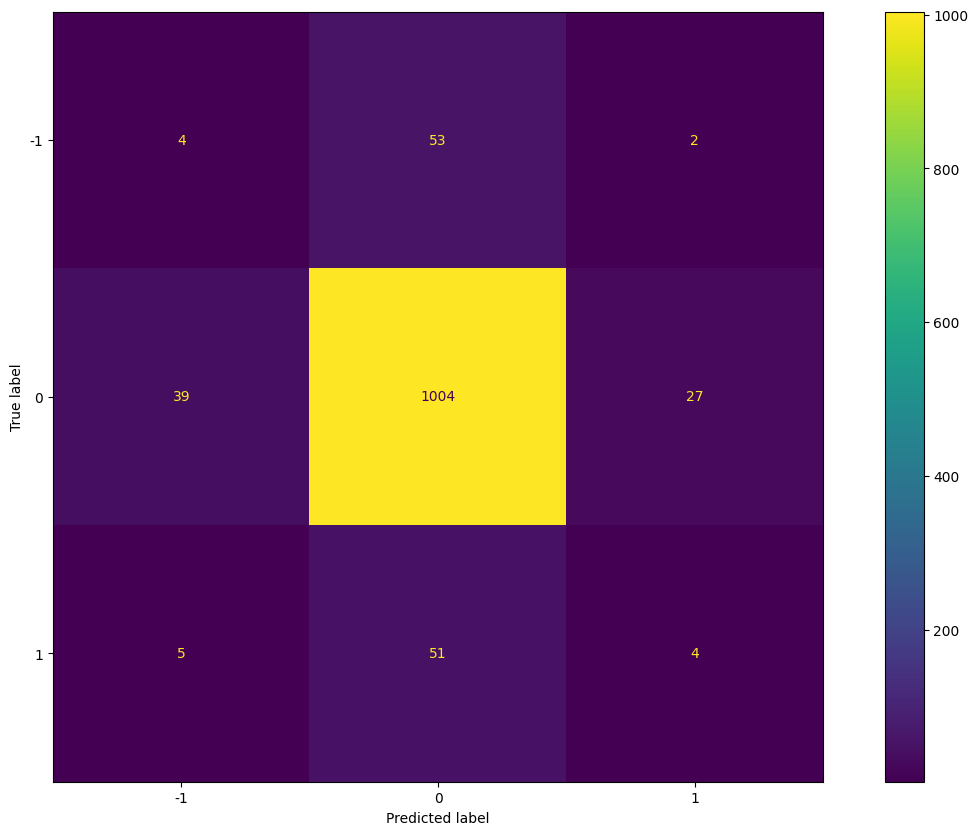

In [41]:
clf = SVC(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## KNN

In [42]:
def objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 3, 15, 1, log=True)
    knn_weights = trial.suggest_categorical('weights', ['uniform','distance'])
    knn_metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    clf = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, metric=knn_metric)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [43]:
study = optuna.create_study(study_name="knn", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 05:18:49,844] A new study created in memory with name: knn
[I 2023-12-17 05:18:53,282] Trial 0 finished with value: 0.3158308751229105 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.3158308751229105.
[I 2023-12-17 05:18:56,819] Trial 1 finished with value: 0.3158308751229105 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.3158308751229105.
[I 2023-12-17 05:18:57,688] Trial 2 finished with value: 0.3158308751229105 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.3158308751229105.
[I 2023-12-17 05:18:58,549] Trial 3 finished with value: 0.3158308751229105 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.3158308751229105.
[I 2023-12-17 05:19:01,859] Trial 4 finished with value: 0.36920890611437457 and parameters: {'n_neighbors

0.3645750249523834


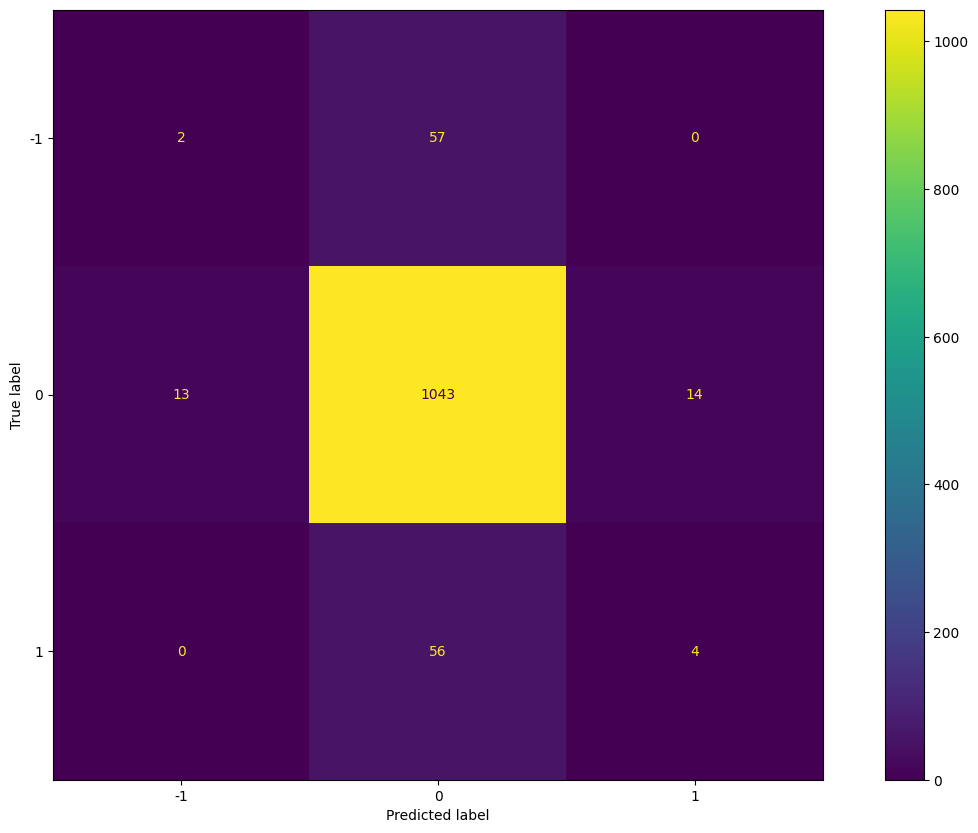

In [44]:
clf = KNeighborsClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## LogReg

In [45]:
def objective(trial):
    logreg_solver = trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga','lbfgs'])
    logereg_C = trial.suggest_float('C', 1e-2, 1e2, log=True)
    clf = LogisticRegression(multi_class='multinomial', solver=logreg_solver, C=logereg_C, max_iter=1000)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [46]:
study = optuna.create_study(study_name="logreg", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 05:23:07,984] A new study created in memory with name: logreg
[I 2023-12-17 05:23:10,029] Trial 0 finished with value: 0.3608632650473654 and parameters: {'solver': 'saga', 'C': 18.3281101935348}. Best is trial 0 with value: 0.3608632650473654.
[I 2023-12-17 05:23:10,089] Trial 1 finished with value: 0.3158308751229105 and parameters: {'solver': 'lbfgs', 'C': 0.06200030495759108}. Best is trial 0 with value: 0.3608632650473654.
[I 2023-12-17 05:23:11,747] Trial 2 finished with value: 0.34052683699742525 and parameters: {'solver': 'saga', 'C': 10.495571428057895}. Best is trial 0 with value: 0.3608632650473654.
[I 2023-12-17 05:23:11,835] Trial 3 finished with value: 0.3158308751229105 and parameters: {'solver': 'sag', 'C': 1.0551990536012967}. Best is trial 0 with value: 0.3608632650473654.
[I 2023-12-17 05:23:12,138] Trial 4 finished with value: 0.36460681435419096 and parameters: {'solver': 'newton-cg', 'C': 40.420745574900586}. Best is trial 4 with value: 0.36460681435

c:\Users\maxod\Desktop\tutorial\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.36962206332992853


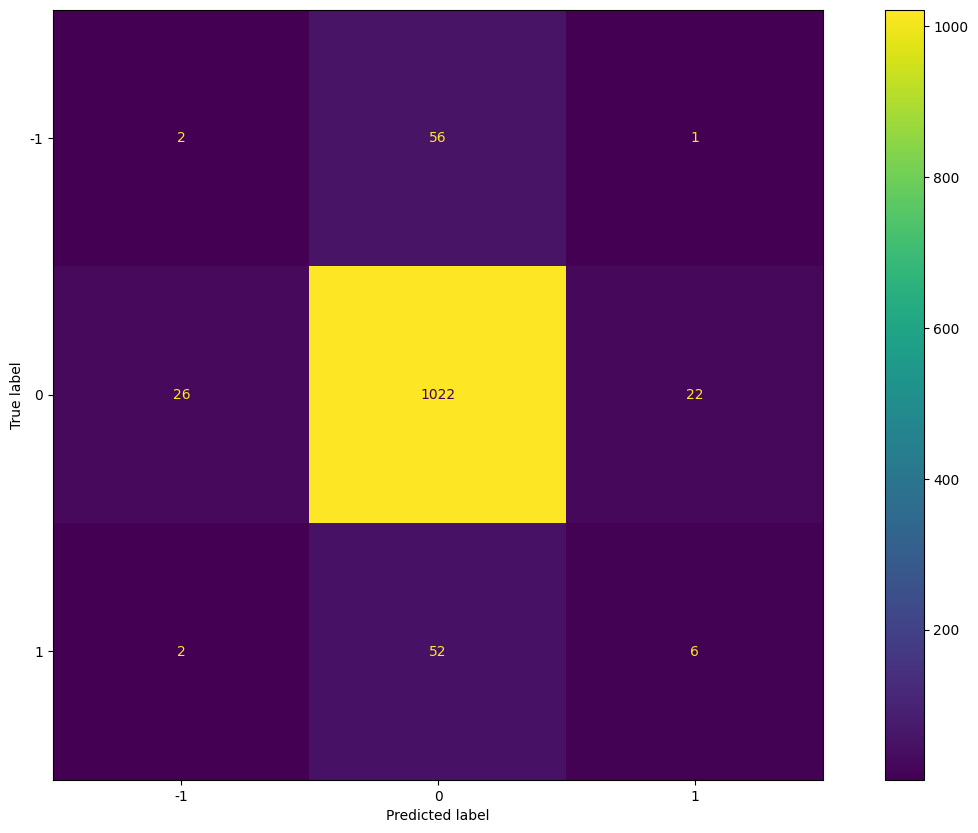

In [47]:
clf = LogisticRegression(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## RandomForest

In [48]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000, log=True)
    max_depth = trial.suggest_int("max_depth", 10, 100, log=True)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [49]:
study = optuna.create_study(study_name="forest", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 05:24:18,741] A new study created in memory with name: forest
[I 2023-12-17 05:24:24,218] Trial 0 finished with value: 0.3648657087408913 and parameters: {'n_estimators': 70, 'max_depth': 78, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3648657087408913.
[I 2023-12-17 05:24:34,280] Trial 1 finished with value: 0.3648657087408913 and parameters: {'n_estimators': 130, 'max_depth': 76, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3648657087408913.
[I 2023-12-17 05:24:38,365] Trial 2 finished with value: 0.36509624695619763 and parameters: {'n_estimators': 107, 'max_depth': 19, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.36509624695619763.
[I 2023-12-17 05:25:05,311] Trial 3 finished with value: 0.3648657087408913 and parameters: {'n_estimators': 501, 'max_depth': 27, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.36509624695619763.
[I 2023-12-17 05:26:11,999] Trial 4 finished with value: 0.3648657087408913 and parameters

0.340407008709954


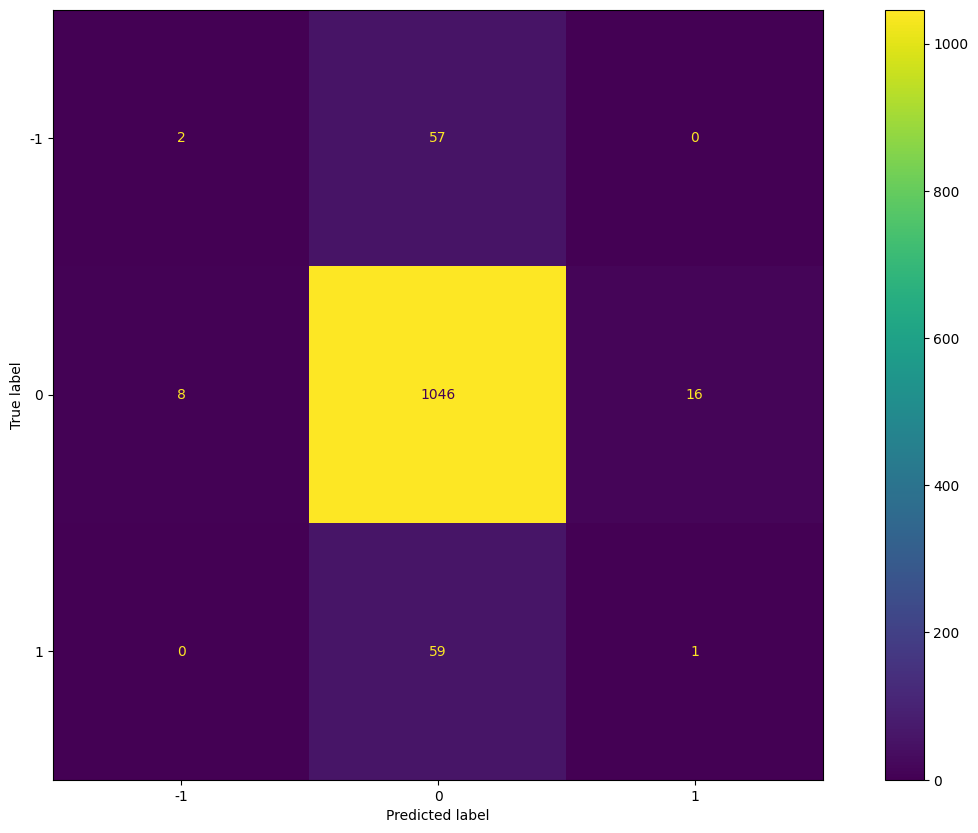

In [50]:
clf = RandomForestClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## Общий рынок - IMOEX

In [51]:
db = create_engine(conn_string) 
conn = db.connect() 
conn.autocommit = True

dataframe_global = pd.read_sql_query('SELECT * FROM global_trade', conn)
conn.close()

print(dataframe_global.shape)
dataframe_global.head()

(13304, 20)


,website,section,url,header,body,tags,body_length,datetime,imoex_price_release,imoex_price_lag_30,rvi_price_release,rvi_price_lag_30,usd_price_release,usd_price_lag_30,imoex_price_diff,imoex_price_diff_percent,rvi_price_diff,rvi_price_diff_percent,usd_price_diff,usd_price_diff_percent
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,2166.77,2168.03,40.45,40.26,70352.0,69975.0,1.26,0.058151,-0.19,-0.469716,-377.0,-0.535877
1,РИА,Экономика,https://ria.ru/20230103/avtomobili-1842908567....,Минпромторг спрогнозировал рост производства а...,Минпромторг прогнозирует в наступившем году ...,"['Экономика', 'Авто', 'Денис Мантуров', 'Росси...",808,2023-01-03 10:20:00,2166.37,2167.18,40.45,40.25,70264.0,70008.0,0.81,0.037390,-0.20,-0.494438,-256.0,-0.364340
2,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879539,Рынок акций РФ открылся ростом индекса МосБирж...,- Рынок акций РФ открылся во вторник ростом ...,['Московская биржа'],1249,2023-01-03 10:22:00,2166.08,2166.96,40.45,40.24,70176.0,70017.0,0.88,0.040626,-0.21,-0.519159,-159.0,-0.226573
3,РИА,Экономика,https://ria.ru/20230103/nissan-1842909188.html,"""АвтоВАЗу"" передадут активы Nissan в России","Подведомственное Минпромторгу ФГУП ""НАМИ"" пе...","['Экономика', 'Авто', 'Денис Мантуров', 'Минис...",1414,2023-01-03 10:29:00,2168.32,2168.95,39.86,40.22,70051.0,70144.0,0.63,0.029055,0.36,0.903161,93.0,0.132760
4,Kommersant,Финансы,https://www.kommersant.ru/doc/5757823,"Индекс Мосбиржи растет на 0,5% на первой торго...",Индекс Московской биржи на открытии торгов рас...,None,598,2023-01-03 10:31:00,2168.03,2170.54,39.89,40.13,69940.0,70053.0,2.51,0.115773,0.24,0.601655,113.0,0.161567


In [52]:
txt_lst = []
txts = dataframe_global.body.copy()

for text in tqdm(txts):
    text = prepare_text(text)
    text = del_stopwords(text)
    text = lemmatize(text)
    txt_lst.append(text)

100%|██████████| 13304/13304 [06:02<00:00, 36.67it/s]


In [53]:
df_global_safe = pd.concat(
    [dataframe_global, pd.DataFrame(txt_lst, columns=['text_clear'])],
    axis=1
)

df_global_safe.to_csv('texts_global.csv', index=False)

In [54]:
df_global = pd.read_csv('texts_global.csv')

for i, text in enumerate(df_global.text_clear):
    df_global.loc[i, 'text_clear'] = prepare_text(text).strip()

In [55]:
p = 0.05

q_l = df_global.imoex_price_diff_percent.quantile(p)
q_u = df_global.imoex_price_diff_percent.quantile(1-p)

df_global['imoex_price_diff_cat'] = 1
df_global.loc[df_global['imoex_price_diff_percent'] <= q_l, 'imoex_price_diff_cat'] = 0
df_global.loc[df_global['imoex_price_diff_percent'] >= q_u, 'imoex_price_diff_cat'] = 2

df_global[['imoex_price_diff_cat']].groupby('imoex_price_diff_cat').value_counts()

imoex_price_diff_cat
0      666
1    11972
2      666
Name: count, dtype: int64

In [56]:
X, y = np.array(df_global['text_clear']), np.array(df_global['imoex_price_diff_cat'].values)

In [57]:
vectorizer = TfidfVectorizer(min_df=50)
vect_x = vectorizer.fit_transform(X)

In [58]:
vect_x

<13304x3822 sparse matrix of type '<class 'numpy.float64'>'
	with 1351450 stored elements in Compressed Sparse Row format>

In [59]:
X_train, X_test, y_train, y_test = train_test_split(vect_x,
                                                    y,
                                                    random_state=23,
                                                    test_size=0.25,
                                                    stratify=y)

X_res, Y_res = X_train, y_train

In [60]:
train_x, valid_x, train_y, valid_y = train_test_split(X_res,
                                                      Y_res,
                                                      random_state=23,
                                                      test_size=0.25,
                                                      stratify=Y_res)

## SVC

In [61]:
def objective(trial):
    svc_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    svc_degree = trial.suggest_int('degree', 2, 5, 1, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    svc_c = trial.suggest_float("C", 1e-2, 1e2, log=True)
    clf = SVC(C=svc_c, gamma=svc_gamma, degree=svc_degree, kernel=svc_kernel)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [62]:
study = optuna.create_study(study_name="svc", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 05:46:26,299] A new study created in memory with name: svc
[I 2023-12-17 05:46:40,642] Trial 0 finished with value: 0.31575246132208157 and parameters: {'kernel': 'poly', 'degree': 3, 'gamma': 'auto', 'C': 12.050930833479141}. Best is trial 0 with value: 0.31575246132208157.
[I 2023-12-17 05:47:14,977] Trial 1 finished with value: 0.34188166598440084 and parameters: {'kernel': 'linear', 'degree': 5, 'gamma': 'auto', 'C': 82.79619712038269}. Best is trial 1 with value: 0.34188166598440084.
[I 2023-12-17 05:47:49,690] Trial 2 finished with value: 0.31575246132208157 and parameters: {'kernel': 'linear', 'degree': 3, 'gamma': 'scale', 'C': 0.5051158626093264}. Best is trial 1 with value: 0.34188166598440084.
[I 2023-12-17 05:48:14,319] Trial 3 finished with value: 0.31575246132208157 and parameters: {'kernel': 'sigmoid', 'degree': 4, 'gamma': 'scale', 'C': 0.010431108662931062}. Best is trial 1 with value: 0.34188166598440084.
[I 2023-12-17 05:48:41,781] Trial 4 finished with

0.3688186932425656


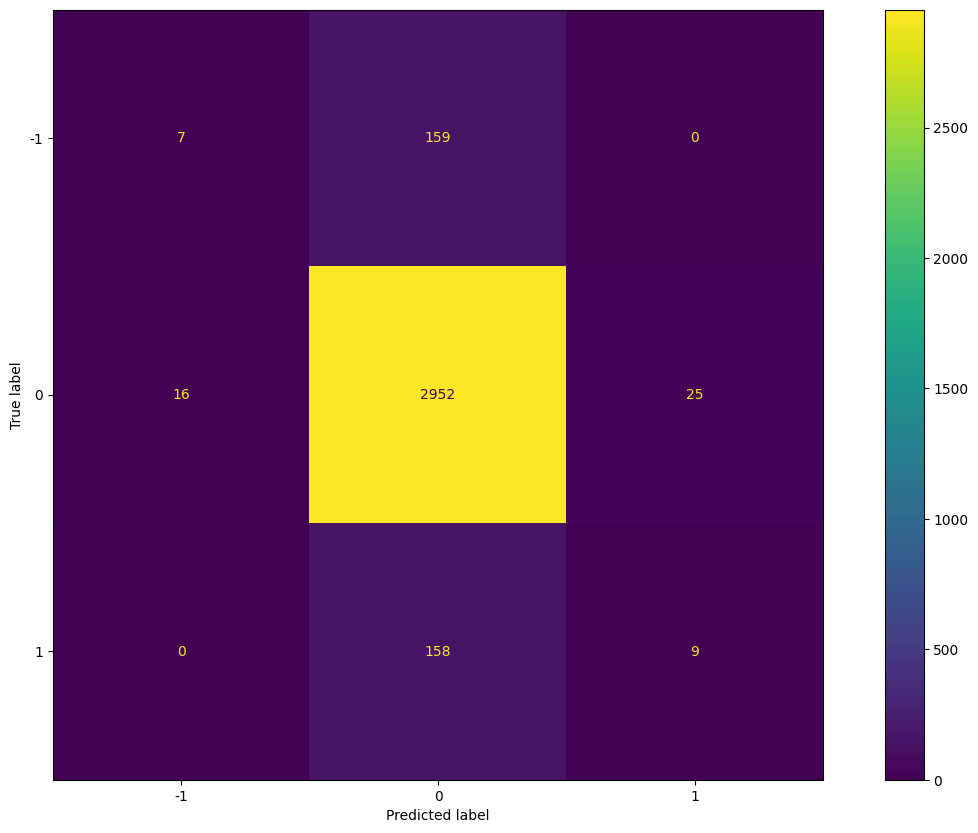

In [63]:
clf = SVC(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## KNN

In [64]:
def objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 3, 15, 1, log=True)
    knn_weights = trial.suggest_categorical('weights', ['uniform','distance'])
    knn_metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    clf = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, metric=knn_metric)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [65]:
study = optuna.create_study(study_name="knn", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 08:04:34,661] A new study created in memory with name: knn
[I 2023-12-17 08:04:39,547] Trial 0 finished with value: 0.3496510796989795 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.3496510796989795.
[I 2023-12-17 08:05:12,358] Trial 1 finished with value: 0.3451779656365955 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.3496510796989795.
[I 2023-12-17 08:05:47,992] Trial 2 finished with value: 0.34025768462499 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.3496510796989795.
[I 2023-12-17 08:06:24,398] Trial 3 finished with value: 0.3699753109201928 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 3 with value: 0.3699753109201928.
[I 2023-12-17 08:07:00,665] Trial 4 finished with value: 0.35369973746738087 and parameters: {'n_neighbors

0.38019215888556035


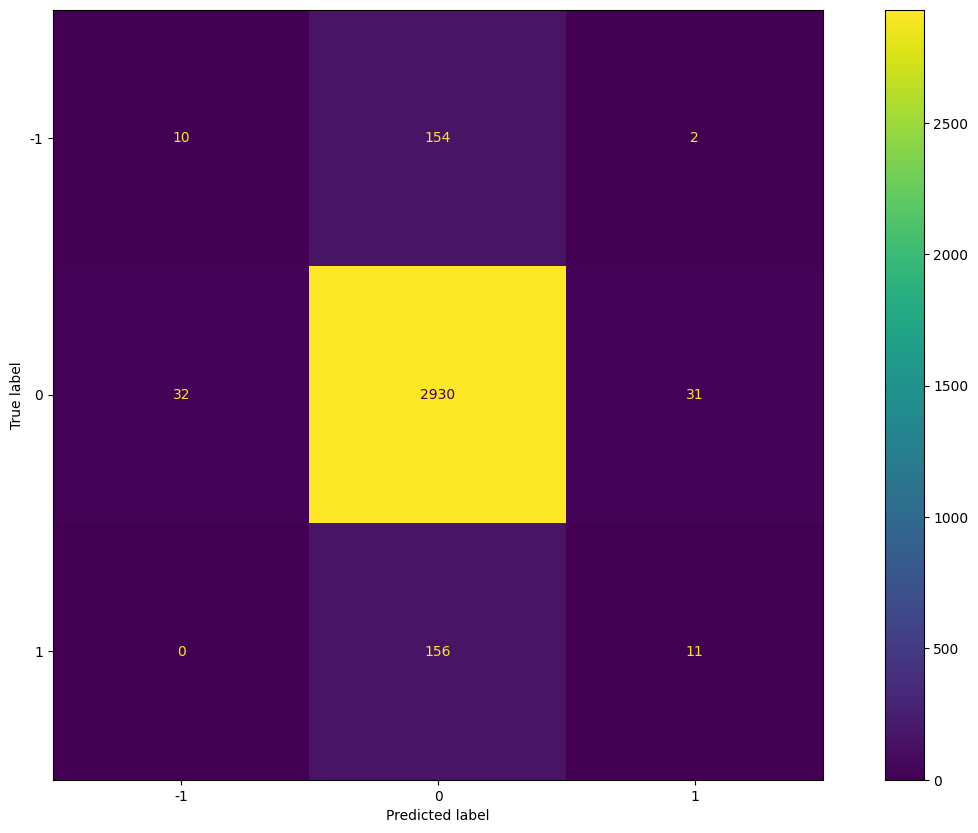

In [66]:
clf = KNeighborsClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## LogReg

In [67]:
def objective(trial):
    logreg_solver = trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga','lbfgs'])
    logereg_C = trial.suggest_float('C', 1e-2, 1e2, log=True)
    clf = LogisticRegression(multi_class='multinomial', solver=logreg_solver, C=logereg_C, max_iter=1000)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [68]:
study = optuna.create_study(study_name="logreg", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 09:07:32,753] A new study created in memory with name: logreg
[I 2023-12-17 09:07:33,014] Trial 0 finished with value: 0.31575246132208157 and parameters: {'solver': 'lbfgs', 'C': 0.0259620295563062}. Best is trial 0 with value: 0.31575246132208157.
[I 2023-12-17 09:07:33,843] Trial 1 finished with value: 0.33078496452483885 and parameters: {'solver': 'sag', 'C': 10.870605748299544}. Best is trial 1 with value: 0.33078496452483885.
[I 2023-12-17 09:07:34,869] Trial 2 finished with value: 0.33428057213223455 and parameters: {'solver': 'newton-cg', 'C': 4.893562176370312}. Best is trial 2 with value: 0.33428057213223455.
[I 2023-12-17 09:07:38,364] Trial 3 finished with value: 0.3438895628101643 and parameters: {'solver': 'lbfgs', 'C': 37.71791948767588}. Best is trial 3 with value: 0.3438895628101643.
[I 2023-12-17 09:07:38,897] Trial 4 finished with value: 0.3297166428380737 and parameters: {'solver': 'sag', 'C': 3.96703018548491}. Best is trial 3 with value: 0.3438895628

c:\Users\maxod\Desktop\tutorial\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.3668730977929397


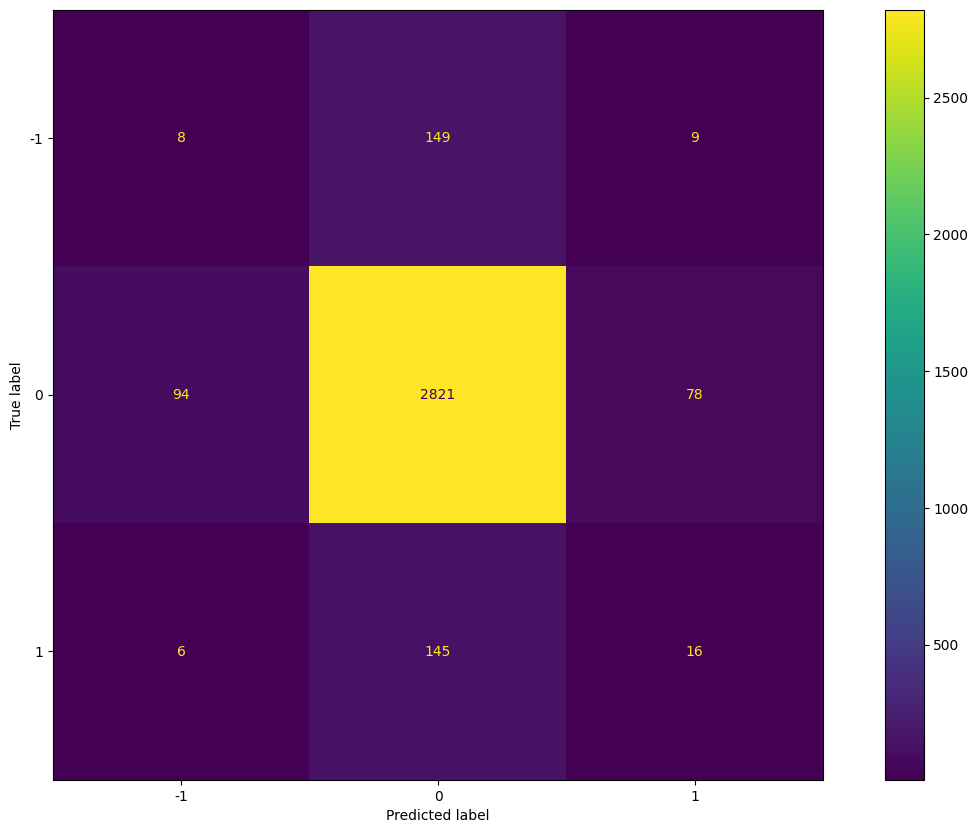

In [69]:
clf = LogisticRegression(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## RandomForest

In [70]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000, log=True)
    max_depth = trial.suggest_int("max_depth", 10, 100, log=True)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [71]:
study = optuna.create_study(study_name="forest", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 09:15:33,922] A new study created in memory with name: forest


[I 2023-12-17 09:16:08,770] Trial 0 finished with value: 0.34625567762736376 and parameters: {'n_estimators': 246, 'max_depth': 34, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.34625567762736376.
[I 2023-12-17 09:16:29,046] Trial 1 finished with value: 0.37760813482124944 and parameters: {'n_estimators': 341, 'max_depth': 14, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.37760813482124944.
[I 2023-12-17 09:16:34,538] Trial 2 finished with value: 0.3544111497739472 and parameters: {'n_estimators': 60, 'max_depth': 21, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.37760813482124944.
[I 2023-12-17 09:17:18,167] Trial 3 finished with value: 0.3408515554812414 and parameters: {'n_estimators': 228, 'max_depth': 53, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.37760813482124944.
[I 2023-12-17 09:17:30,524] Trial 4 finished with value: 0.34104033339301904 and parameters: {'n_estimators': 54, 'max_depth': 91, 'c

0.35288505912524687


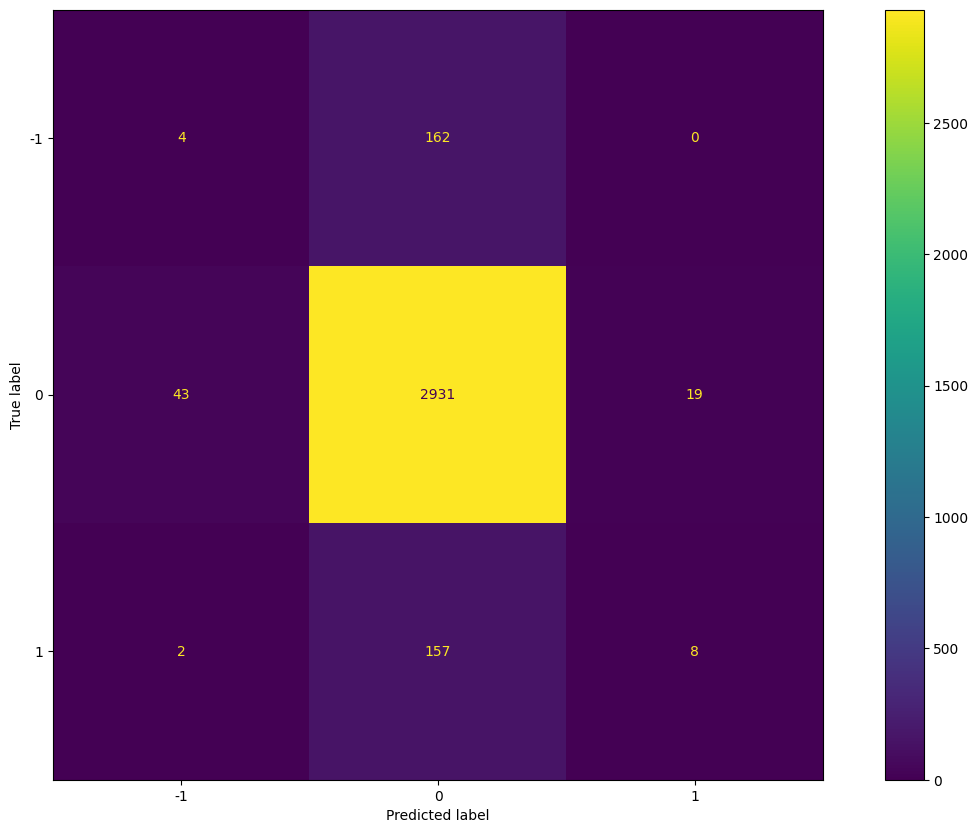

In [72]:
clf = RandomForestClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## Общий рынок - RVI

In [73]:
p = 0.05

q_l = df_global.rvi_price_diff_percent.quantile(p)
q_u = df_global.rvi_price_diff_percent.quantile(1-p)

df_global['rvi_price_diff_cat'] = 1
df_global.loc[df_global['rvi_price_diff_percent'] <= q_l, 'rvi_price_diff_cat'] = 0
df_global.loc[df_global['rvi_price_diff_percent'] >= q_u, 'rvi_price_diff_cat'] = 2

df_global[['rvi_price_diff_cat']].groupby('rvi_price_diff_cat').value_counts()

rvi_price_diff_cat
0      666
1    11972
2      666
Name: count, dtype: int64

In [74]:
X, y = np.array(df_global['text_clear']), np.array(df_global['rvi_price_diff_cat'].values)

In [75]:
vectorizer = TfidfVectorizer(min_df=50)
vect_x = vectorizer.fit_transform(X)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(vect_x,
                                                    y,
                                                    random_state=23,
                                                    test_size=0.25,
                                                    stratify=y)

X_res, Y_res = X_train, y_train

In [77]:
train_x, valid_x, train_y, valid_y = train_test_split(X_res,
                                                      Y_res,
                                                      random_state=23,
                                                      test_size=0.25,
                                                      stratify=Y_res)

## SVC

In [78]:
def objective(trial):
    svc_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    svc_degree = trial.suggest_int('degree', 2, 5, 1, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    svc_c = trial.suggest_float("C", 1e-2, 1e2, log=True)
    clf = SVC(C=svc_c, gamma=svc_gamma, degree=svc_degree, kernel=svc_kernel)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [79]:
study = optuna.create_study(study_name="svc", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 10:06:47,431] A new study created in memory with name: svc
[I 2023-12-17 10:07:24,442] Trial 0 finished with value: 0.3586254125120285 and parameters: {'kernel': 'linear', 'degree': 4, 'gamma': 'auto', 'C': 96.19932565161531}. Best is trial 0 with value: 0.3586254125120285.
[I 2023-12-17 10:07:53,865] Trial 1 finished with value: 0.31575246132208157 and parameters: {'kernel': 'sigmoid', 'degree': 2, 'gamma': 'scale', 'C': 1.8917905605618102}. Best is trial 0 with value: 0.3586254125120285.
[I 2023-12-17 10:08:29,786] Trial 2 finished with value: 0.31575246132208157 and parameters: {'kernel': 'linear', 'degree': 4, 'gamma': 'scale', 'C': 0.1700741891070541}. Best is trial 0 with value: 0.3586254125120285.
[I 2023-12-17 10:09:56,935] Trial 3 finished with value: 0.31575246132208157 and parameters: {'kernel': 'rbf', 'degree': 2, 'gamma': 'scale', 'C': 0.8646569677363141}. Best is trial 0 with value: 0.3586254125120285.
[I 2023-12-17 10:12:08,635] Trial 4 finished with value:

0.36804747849253433


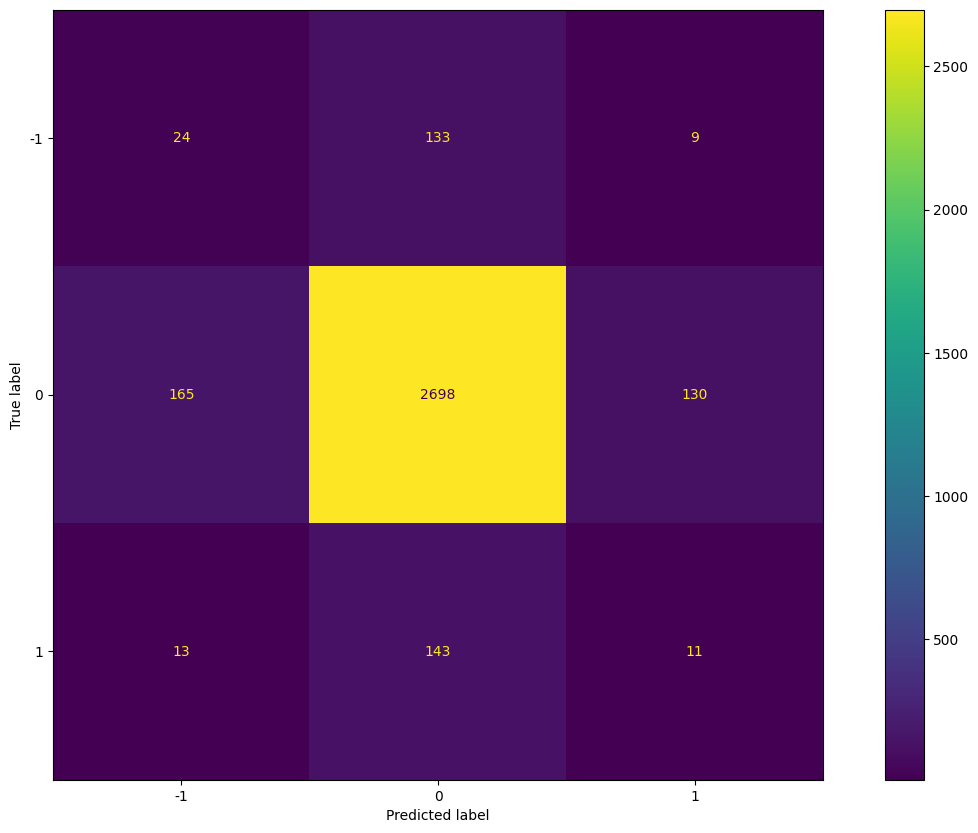

In [80]:
clf = SVC(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## KNN

In [81]:
def objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 3, 15, 1, log=True)
    knn_weights = trial.suggest_categorical('weights', ['uniform','distance'])
    knn_metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    clf = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, metric=knn_metric)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [82]:
study = optuna.create_study(study_name="knn", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 11:17:00,078] A new study created in memory with name: knn
[I 2023-12-17 11:17:31,752] Trial 0 finished with value: 0.3341307239294748 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.3341307239294748.
[I 2023-12-17 11:18:06,830] Trial 1 finished with value: 0.3352546482062008 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.3352546482062008.
[I 2023-12-17 11:18:42,258] Trial 2 finished with value: 0.3341307239294748 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value: 0.3352546482062008.
[I 2023-12-17 11:19:17,898] Trial 3 finished with value: 0.33043301774787026 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 1 with value: 0.3352546482062008.
[I 2023-12-17 11:19:23,664] Trial 4 finished with value: 0.350967176724307 and parameters: {'n_neighbors'

0.3592966986389752


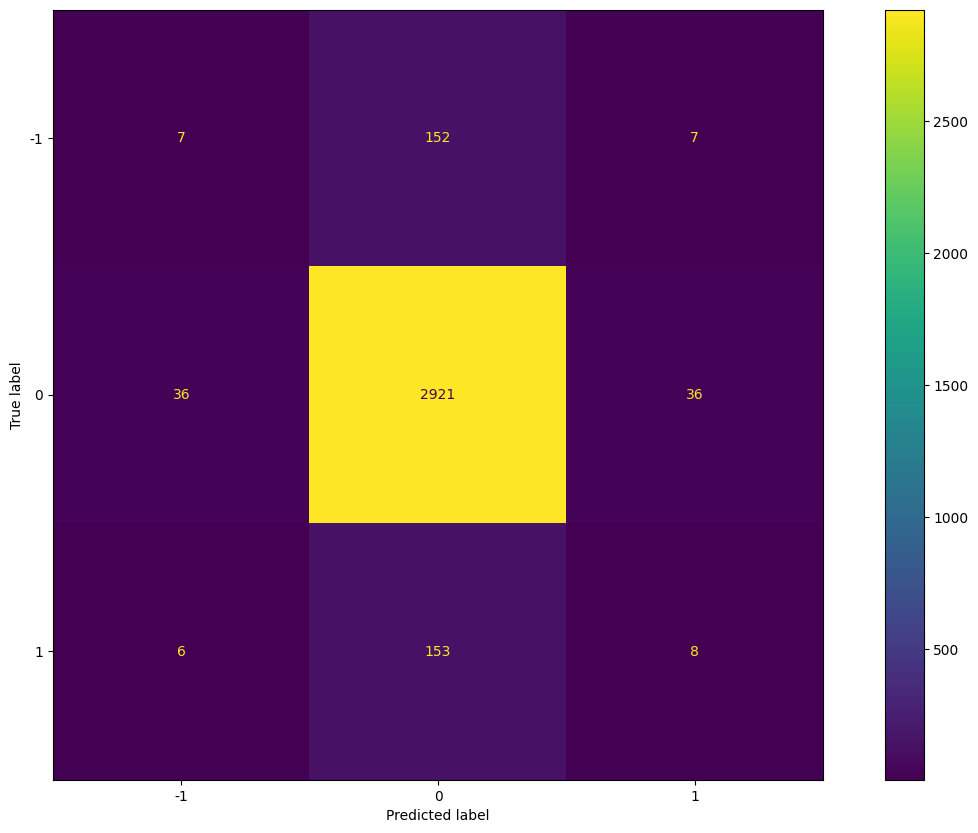

In [83]:
clf = KNeighborsClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## LogReg

In [84]:
def objective(trial):
    logreg_solver = trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga','lbfgs'])
    logereg_C = trial.suggest_float('C', 1e-2, 1e2, log=True)
    clf = LogisticRegression(multi_class='multinomial', solver=logreg_solver, C=logereg_C, max_iter=1000)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [85]:
study = optuna.create_study(study_name="logreg", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 11:40:26,817] A new study created in memory with name: logreg
[I 2023-12-17 11:40:27,169] Trial 0 finished with value: 0.31575246132208157 and parameters: {'solver': 'sag', 'C': 0.7321196140014425}. Best is trial 0 with value: 0.31575246132208157.
[I 2023-12-17 11:40:29,810] Trial 1 finished with value: 0.31575246132208157 and parameters: {'solver': 'saga', 'C': 0.11361713437201175}. Best is trial 0 with value: 0.31575246132208157.
[I 2023-12-17 11:40:30,448] Trial 2 finished with value: 0.3340135321800386 and parameters: {'solver': 'sag', 'C': 7.760474567987385}. Best is trial 2 with value: 0.3340135321800386.
[I 2023-12-17 11:40:32,037] Trial 3 finished with value: 0.36073234494611944 and parameters: {'solver': 'sag', 'C': 44.54283479853514}. Best is trial 3 with value: 0.36073234494611944.
[I 2023-12-17 11:40:32,313] Trial 4 finished with value: 0.31575246132208157 and parameters: {'solver': 'sag', 'C': 0.013420621095120714}. Best is trial 3 with value: 0.3607323449461

0.3564411990204179


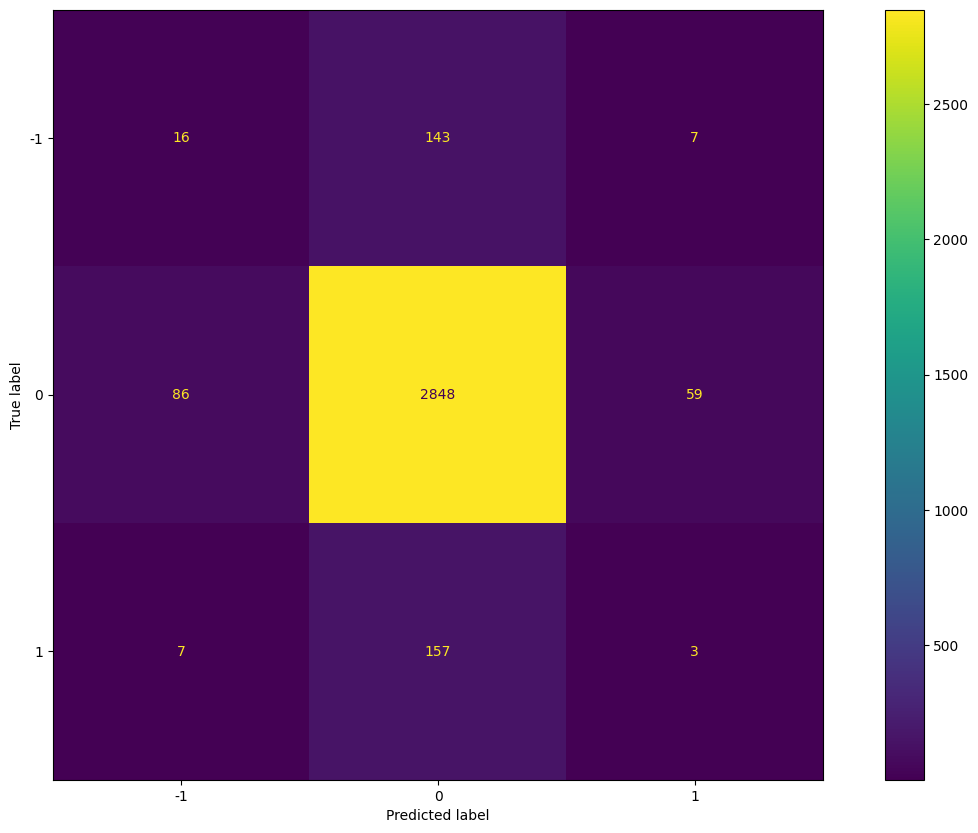

In [86]:
clf = LogisticRegression(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## RandomForest

In [87]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000, log=True)
    max_depth = trial.suggest_int("max_depth", 10, 100, log=True)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [88]:
study = optuna.create_study(study_name="forest", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 11:44:29,221] A new study created in memory with name: forest


[I 2023-12-17 11:44:38,764] Trial 0 finished with value: 0.3309204238371645 and parameters: {'n_estimators': 96, 'max_depth': 23, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3309204238371645.
[I 2023-12-17 11:45:05,897] Trial 1 finished with value: 0.3207648055031776 and parameters: {'n_estimators': 118, 'max_depth': 94, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3309204238371645.
[I 2023-12-17 11:45:26,145] Trial 2 finished with value: 0.33558589225889124 and parameters: {'n_estimators': 296, 'max_depth': 16, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.33558589225889124.
[I 2023-12-17 11:45:45,308] Trial 3 finished with value: 0.31575246132208157 and parameters: {'n_estimators': 81, 'max_depth': 86, 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.33558589225889124.
[I 2023-12-17 11:46:21,225] Trial 4 finished with value: 0.31567841316733486 and parameters: {'n_estimators': 196, 'max_depth': 45, 'class_weight': 'balance

0.35145506458383474


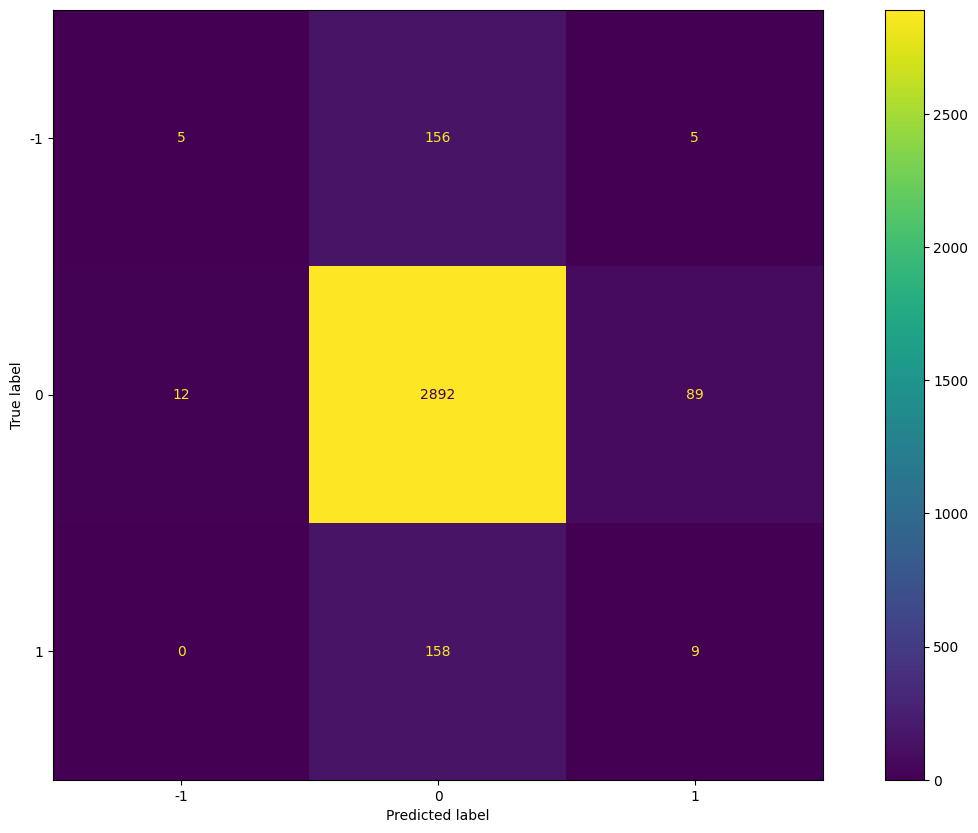

In [89]:
clf = RandomForestClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## Общий рынок - Фьючерс на доллар

In [90]:
p = 0.05

q_l = df_global.usd_price_diff_percent.quantile(p)
q_u = df_global.usd_price_diff_percent.quantile(1-p)

df_global['usd_price_diff_cat'] = 1
df_global.loc[df_global['usd_price_diff_percent'] <= q_l, 'usd_price_diff_cat'] = 0
df_global.loc[df_global['usd_price_diff_percent'] >= q_u, 'usd_price_diff_cat'] = 2

df_global[['usd_price_diff_cat']].groupby('usd_price_diff_cat').value_counts()

usd_price_diff_cat
0      666
1    11972
2      666
Name: count, dtype: int64

In [91]:
X, y = np.array(df_global['text_clear']), np.array(df_global['usd_price_diff_cat'].values)

In [92]:
vectorizer = TfidfVectorizer(min_df=50)
vect_x = vectorizer.fit_transform(X)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(vect_x,
                                                    y,
                                                    random_state=23,
                                                    test_size=0.25,
                                                    stratify=y)

X_res, Y_res = X_train, y_train

In [94]:
train_x, valid_x, train_y, valid_y = train_test_split(X_res,
                                                      Y_res,
                                                      random_state=23,
                                                      test_size=0.25,
                                                      stratify=Y_res)

## SVC

In [95]:
def objective(trial):
    svc_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    svc_degree = trial.suggest_int('degree', 2, 5, 1, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    svc_c = trial.suggest_float("C", 1e-2, 1e2, log=True)
    clf = SVC(C=svc_c, gamma=svc_gamma, degree=svc_degree, kernel=svc_kernel)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [96]:
study = optuna.create_study(study_name="svc", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 11:57:08,697] A new study created in memory with name: svc
[I 2023-12-17 11:59:00,458] Trial 0 finished with value: 0.35074492827219456 and parameters: {'kernel': 'poly', 'degree': 3, 'gamma': 'scale', 'C': 53.7294151204234}. Best is trial 0 with value: 0.35074492827219456.
[I 2023-12-17 11:59:14,471] Trial 1 finished with value: 0.31575246132208157 and parameters: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto', 'C': 21.45339569165654}. Best is trial 0 with value: 0.35074492827219456.
[I 2023-12-17 11:59:46,135] Trial 2 finished with value: 0.31575246132208157 and parameters: {'kernel': 'linear', 'degree': 2, 'gamma': 'scale', 'C': 0.015825020601258472}. Best is trial 0 with value: 0.35074492827219456.
[I 2023-12-17 12:00:20,462] Trial 3 finished with value: 0.31575246132208157 and parameters: {'kernel': 'linear', 'degree': 4, 'gamma': 'auto', 'C': 0.10376594500331215}. Best is trial 0 with value: 0.35074492827219456.
[I 2023-12-17 12:01:49,351] Trial 4 finished with val

0.3566335345075525


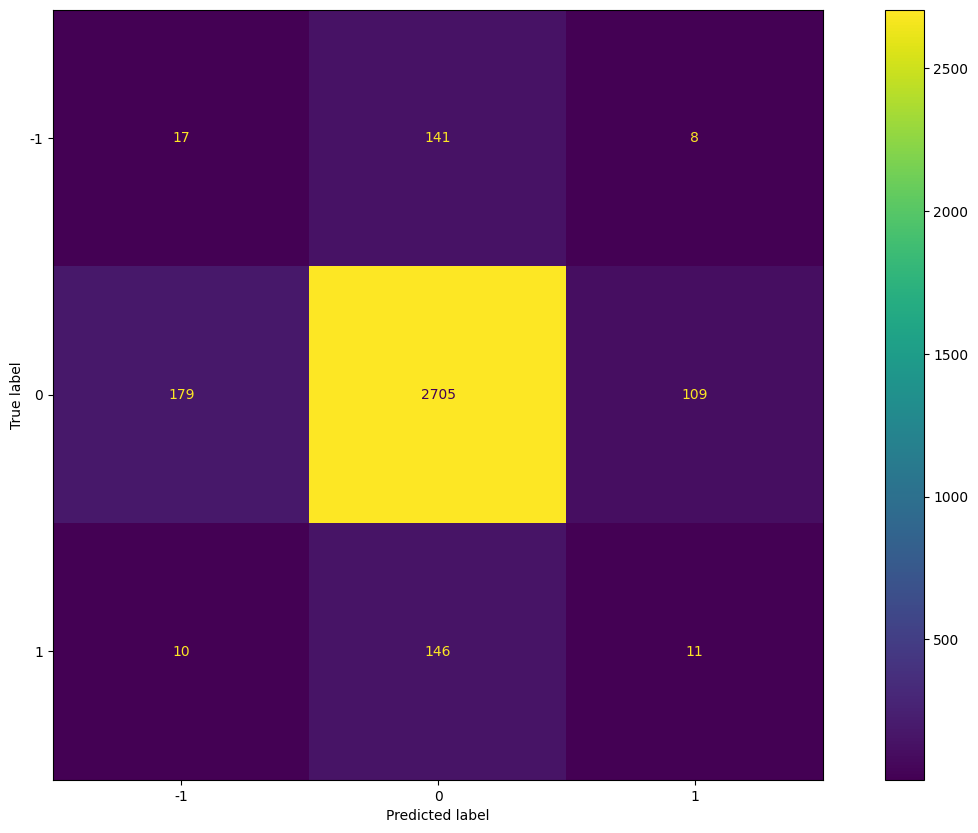

In [97]:
clf = SVC(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## KNN

In [98]:
def objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 3, 15, 1, log=True)
    knn_weights = trial.suggest_categorical('weights', ['uniform','distance'])
    knn_metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    clf = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, metric=knn_metric)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [99]:
study = optuna.create_study(study_name="knn", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 13:54:55,166] A new study created in memory with name: knn
[I 2023-12-17 13:55:00,046] Trial 0 finished with value: 0.3356214333373759 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.3356214333373759.
[I 2023-12-17 13:55:32,879] Trial 1 finished with value: 0.33630614399845166 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 1 with value: 0.33630614399845166.
[I 2023-12-17 13:56:08,296] Trial 2 finished with value: 0.3457109562171122 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 2 with value: 0.3457109562171122.
[I 2023-12-17 13:56:44,132] Trial 3 finished with value: 0.3729921449466296 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 3 with value: 0.3729921449466296.
[I 2023-12-17 13:56:49,914] Trial 4 finished with value: 0.32615427927927926 and parameters: {'n_neig

0.35318711508348993


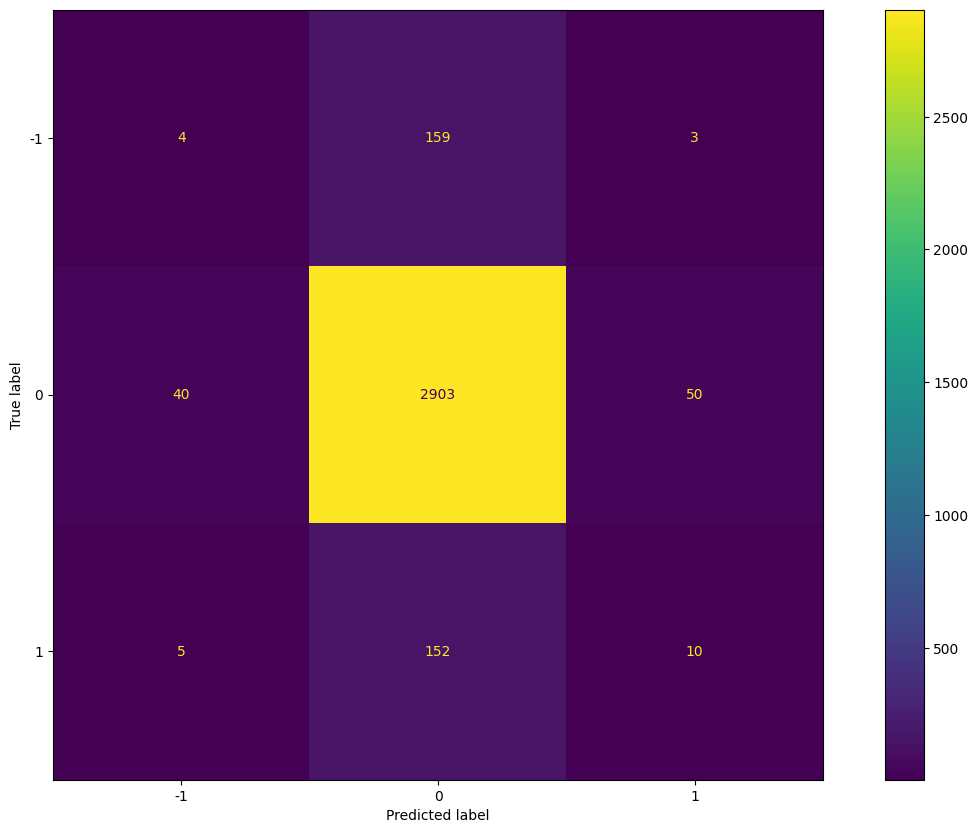

In [100]:
clf = KNeighborsClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## LogReg

In [101]:
def objective(trial):
    logreg_solver = trial.suggest_categorical('solver', ['newton-cg', 'sag', 'saga','lbfgs'])
    logereg_C = trial.suggest_float('C', 1e-2, 1e2, log=True)
    clf = LogisticRegression(multi_class='multinomial', solver=logreg_solver, C=logereg_C, max_iter=1000)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [102]:
study = optuna.create_study(study_name="logreg", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 15:00:23,747] A new study created in memory with name: logreg
[I 2023-12-17 15:00:27,747] Trial 0 finished with value: 0.3734363621831875 and parameters: {'solver': 'lbfgs', 'C': 38.08534698109206}. Best is trial 0 with value: 0.3734363621831875.
[I 2023-12-17 15:00:28,168] Trial 1 finished with value: 0.31575246132208157 and parameters: {'solver': 'newton-cg', 'C': 0.02599476933858757}. Best is trial 0 with value: 0.3734363621831875.
[I 2023-12-17 15:00:31,564] Trial 2 finished with value: 0.31575246132208157 and parameters: {'solver': 'saga', 'C': 0.0670102214217177}. Best is trial 0 with value: 0.3734363621831875.
[I 2023-12-17 15:00:32,145] Trial 3 finished with value: 0.3297310113739888 and parameters: {'solver': 'sag', 'C': 4.865777466944458}. Best is trial 0 with value: 0.3734363621831875.
[I 2023-12-17 15:00:35,810] Trial 4 finished with value: 0.31575246132208157 and parameters: {'solver': 'saga', 'C': 0.0637560295493693}. Best is trial 0 with value: 0.3734363621

c:\Users\maxod\Desktop\tutorial\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.35686870570725326


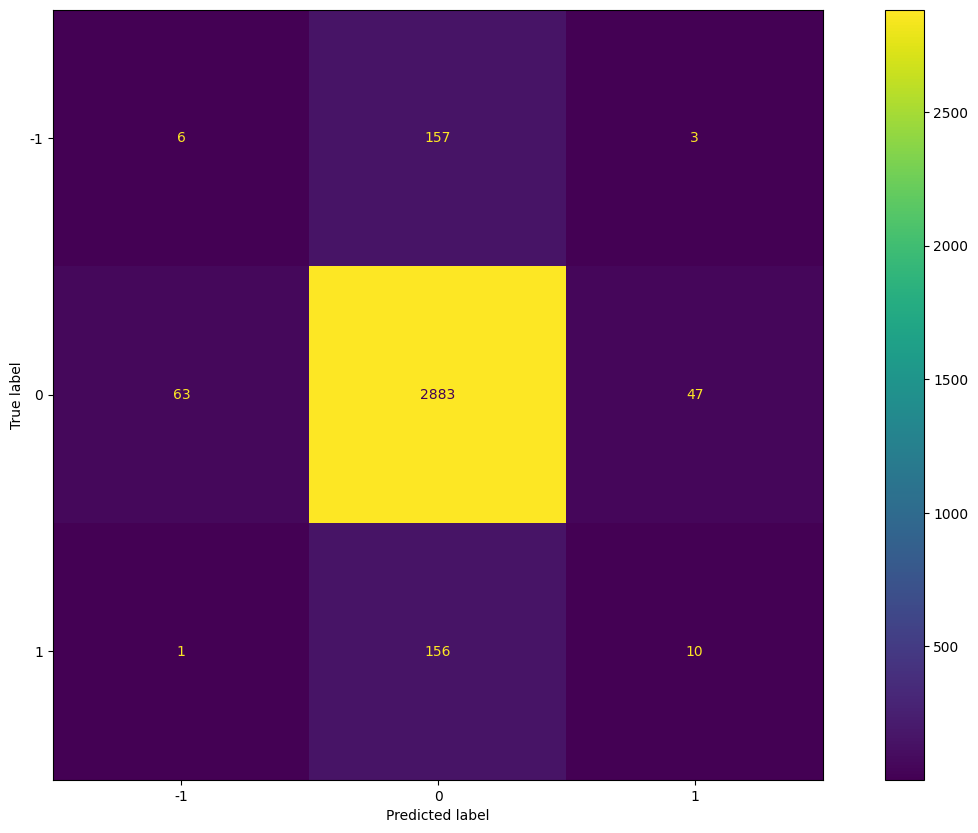

In [103]:
clf = LogisticRegression(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)

## RandomForest

In [104]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000, log=True)
    max_depth = trial.suggest_int("max_depth", 10, 100, log=True)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight)
    clf.fit(train_x, train_y)
    cl = clf.predict(valid_x)
    f1 = f1_score(valid_y, cl, average='macro')
    
    return f1

In [105]:
study = optuna.create_study(study_name="forest", direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-12-17 15:07:10,061] A new study created in memory with name: forest
[I 2023-12-17 15:08:12,712] Trial 0 finished with value: 0.3207648055031776 and parameters: {'n_estimators': 252, 'max_depth': 91, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3207648055031776.
[I 2023-12-17 15:09:00,944] Trial 1 finished with value: 0.33150337837837834 and parameters: {'n_estimators': 196, 'max_depth': 78, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.33150337837837834.
[I 2023-12-17 15:10:59,858] Trial 2 finished with value: 0.3412408377182517 and parameters: {'n_estimators': 801, 'max_depth': 33, 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.3412408377182517.
[I 2023-12-17 15:11:42,255] Trial 3 finished with value: 0.3453038648706684 and parameters: {'n_estimators': 646, 'max_depth': 15, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.3453038648706684.
[I 2023-12-17 15:11:44,889] Trial 4 finished with value: 0.35981936122795005 and

0.3495207951089474


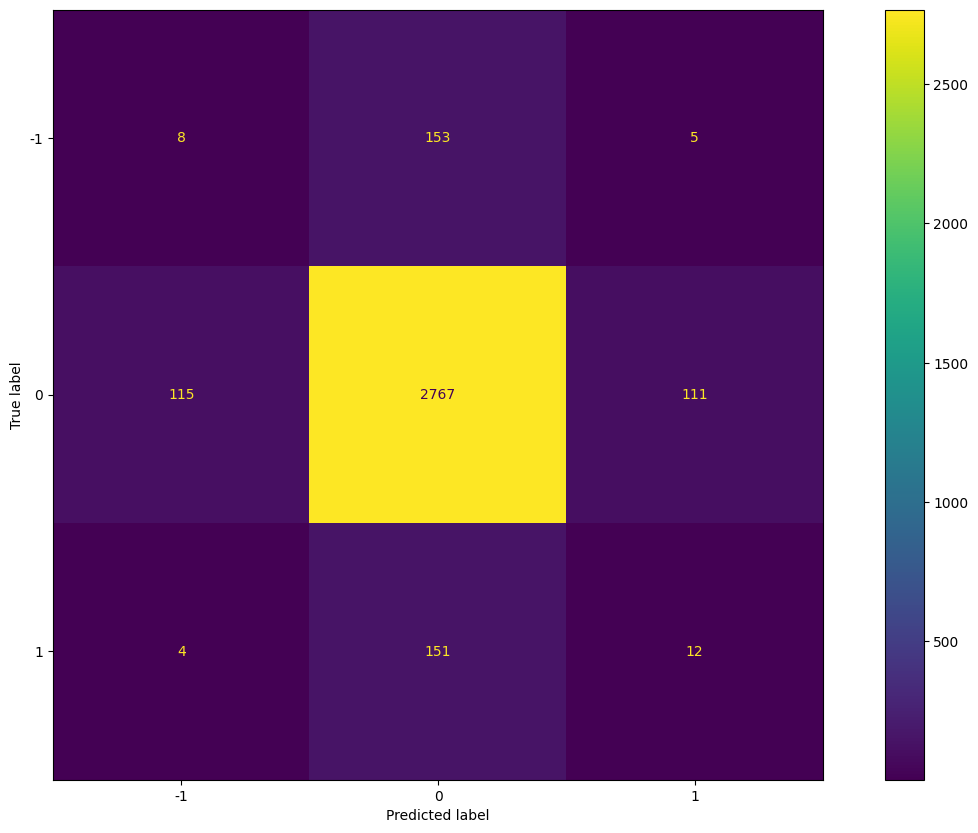

In [106]:
clf = RandomForestClassifier(**study.best_params)
clf.fit(X_res, Y_res)
pred_test = clf.predict(X_test)
print(f1_score(y_test, pred_test, average='macro'))
plot_confusion_matrix(y_test, pred_test, clf)